1. create folder in local runtime
2. upload dataset zip to local runtime
3. unzip

In [ ]:
!unzip /content/dataset_cropped_224x224_newest.zip -d /content/dataset_cropped_224x224_newest

Archive:  /content/dataset_cropped_224x224_newest-20251128T144454Z-1-001.zip
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/b--50-_jpg.rf.fa7945cbc17bad7cb2a6f51a138c0b99_tile1.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/125_jpg.rf.f37f515011dff4fbb0b882e824432b93_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/a--32-_jpg.rf.f7a6bf6256f4a4bc417a23dd47536c7f_tile1.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/a--87-_jpg.rf.e99dd21bd33d8f9c6b36c8d8b908f5f8_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/c--142-_jpg.rf.fb5f460875d029f6681a6b655358776e_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/156_jpg.rf.746421f245b72dbf541074bf5d373bdd_tile0.jpg  
  inflating: /content/dataset_crop

In [6]:
!pip install torchmetrics

In [7]:
import os
import time
import torch
import cv2
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

import albumentations as A
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [8]:
thop_available = False
try:
    # Check if thop is installed, if not, install it
    import importlib.util
    if not importlib.util.find_spec("thop"):
        print("Installing thop...")
        !pip install thop
        import thop # Re-import after installation attempt
    from thop import profile
    thop_available = True
except Exception as e:
    print(f"THOP library import failed: {e}")
    thop_available = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MicroplasticsDataset(Dataset):
    def __init__(self, df, images_dir, transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_files = df['filename'].unique().tolist()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        records = self.df[self.df['filename'] == img_file]
        boxes = records[['xmin','ymin','xmax','ymax']].values
        labels = records['label'].values

        if self.transforms:
            aug = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img = aug['image']
            boxes = aug['bboxes']
            labels = aug['class_labels']

        img_tensor = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        return img_tensor, {"boxes": boxes_tensor, "labels": labels_tensor}


def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

crop_train_dir = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train"
crop_val_dir   = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid"

train_df = pd.read_csv(os.path.join(crop_train_dir, "_annotations.csv"))
val_df   = pd.read_csv(os.path.join(crop_val_dir, "_annotations.csv"))

# encodings
unique_classes = sorted(train_df['class'].unique())
class_to_idx = {cls: idx+1 for idx, cls in enumerate(unique_classes)}

train_df["label"] = train_df["class"].map(class_to_idx)
val_df["label"]   = val_df["class"].map(class_to_idx)

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_dataset = MicroplasticsDataset(train_df, crop_train_dir, transforms=train_transforms)
val_dataset   = MicroplasticsDataset(val_df, crop_val_dir, transforms=None)

# Increased val_loader batch_size from 1 to 16 for faster validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn, num_workers=1)
val_loader   = DataLoader(val_dataset,   batch_size=1,  shuffle=False, collate_fn=collate_fn, num_workers=1)

print(f"Loaded {len(train_dataset)} train and {len(val_dataset)} validation images.")

Installing thop...
Using device: cuda
Loaded 1869 train and 647 validation images.


In [9]:
import os

train_files_fs = [f for f in os.listdir(crop_train_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
val_files_fs   = [f for f in os.listdir(crop_val_dir)   if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print("train images on disk:", len(train_files_fs))
print("val images on disk:",   len(val_files_fs))
print("total on disk:",        len(train_files_fs) + len(val_files_fs))

print("train in CSV:", train_df["filename"].nunique())
print("val in CSV:",   val_df["filename"].nunique())


train images on disk: 2308
val images on disk: 816
total on disk: 3124
train in CSV: 1869
val in CSV: 647


# Model Setup

In [10]:
class CustomCNNBackbone(nn.Module):
    def __init__(self, channels=(32, 64, 128, 256)):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.pools  = nn.ModuleList()

        in_ch = 3
        for ch in channels:
            block = nn.Sequential(
                nn.Conv2d(in_ch, ch, 3, 1, 1),
                nn.BatchNorm2d(ch),
                nn.ReLU(),
                nn.Conv2d(ch, ch, 3, 1, 1),
                nn.BatchNorm2d(ch),
                nn.ReLU(),
            )
            self.blocks.append(block)
            self.pools.append(nn.MaxPool2d(2))
            in_ch = ch

        self.out_channels = channels[-1]
        self.channels = channels

    def forward(self, x):
        for block, pool in zip(self.blocks, self.pools):
            x = pool(block(x))
        return x

In [11]:
def build_model(channels):
    backbone = CustomCNNBackbone(channels)
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),),
        aspect_ratios=((0.5, 1.0, 2.0),),
    )

    model = FasterRCNN(
        backbone,
        num_classes=len(unique_classes)+1,
        rpn_anchor_generator=anchor_generator,
        min_size=224,
        max_size=224,
        image_mean=[0.0, 0.0, 0.0],
        image_std=[1.0, 1.0, 1.0],
    ).to(device)
    return model

In [ ]:
def run_depth_experiment(channels, num_epochs=30, tag="customcnn"):
    model = build_model(channels)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    metric = MeanAveragePrecision().to(device)

    history = []
    print(f"\nExperiment {tag}, channels={channels}, blocks={len(channels)}")
    train_start_time = time.time()

    base_results_dir = "/models"
    os.makedirs(base_results_dir, exist_ok=True)

    # Create a unique directory for this experiment
    experiment_dir = os.path.join(base_results_dir, tag)
    os.makedirs(experiment_dir, exist_ok=True)

    for epoch in range(1, num_epochs + 1):
        # train
        model.train()
        epoch_loss = 0.0
        for images, targets in train_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            losses = model(images, targets)
            total_loss = sum(losses.values())
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        scheduler.step()
        epoch_loss_avg = epoch_loss / len(train_loader)

        # val mAP
        model.eval()
        metric.reset()
        with torch.no_grad():
            for images, targets in val_loader:
                images  = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images)
                metric.update(preds, targets)

        m = metric.compute()
        map_50     = float(m["map_50"])
        map_50_95  = float(m["map"])

        history.append({
            "epoch": epoch,
            "loss": epoch_loss_avg,
            "mAP_50": map_50,
            "mAP_50_95": map_50_95,
        })

        print(
            f"Epoch {epoch:02d}: "
            f"loss={epoch_loss_avg:.4f}, "
            f"mAP@50={map_50:.3f}, "
            f"mAP@50:95={map_50_95:.3f}"
        )

    # Save the final model and history in the experiment-specific directory
    torch.save(model.state_dict(), os.path.join(experiment_dir, f"{tag}_final.pth"))

    total_time = time.time() - train_start_time
    print(f"Training completed in {total_time/60:.2f} min.")

    df_hist = pd.DataFrame(history)
    df_hist.to_csv(os.path.join(experiment_dir, f"{tag}_history.csv"), index=False)

    #  MACs / params
    macs = None
    if thop_available:
        from thop import profile
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
        print(f"MACs: {macs/1e9:.2f} G")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total params: {total_params/1e6:.2f} M")

    # Inference time
    model.eval()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    inf_start = time.time()
    total_images = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = [img.to(device) for img in images]
            _ = model(images)
            total_images += len(images)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    inf_end = time.time()

    avg_inf_time = (inf_end - inf_start) / max(total_images, 1)
    fps = 1.0 / avg_inf_time if avg_inf_time > 0 else 0.0
    print(f"Avg inference: {avg_inf_time*1000:.2f} ms/img, FPS={fps:.2f}")

    summary = {
        "model_tag": tag,
        "channels": channels,
        "num_blocks": len(channels),
        "total_train_time_sec": total_time,
        "best_mAP_50": float(df_hist["mAP_50"].max()),
        "best_mAP_50_95": float(df_hist["mAP_50_95"].max()),
        "inference_time_sec": avg_inf_time,
        "FPS": fps,
        "MACs_G": macs/1e9 if macs is not None else None,
        "params_M": total_params/1e6,
    }
    return df_hist, summary

In [ ]:
experiments = [
    ("depth2", (32, 64)),
    ("depth3", (32, 64, 128)),
    ("depth4", (32, 64, 128, 256)), # original custom CNN
    ("depth5_v1", (32, 64, 128, 256, 256)),
    ("depth5_v2", (32, 64, 128, 256, 512)),
    ("depth6", (32, 64, 128, 256, 512, 1024)),
]

summaries = []
histories = {}

for tag, ch in experiments:
    df_hist, summary = run_depth_experiment(channels=ch,
                                            num_epochs=30,
                                            tag=f"customcnn_{tag}")
    histories[tag] = df_hist
    summaries.append(summary)

df_depth_results = pd.DataFrame(summaries)
print(df_depth_results)



Experiment customcnn_depth2, channels=(32, 64), blocks=2
Epoch 01: loss=0.5576, mAP@50=0.154, mAP@50:95=0.041
Epoch 02: loss=0.4898, mAP@50=0.273, mAP@50:95=0.079
Epoch 03: loss=0.4805, mAP@50=0.348, mAP@50:95=0.102
Epoch 04: loss=0.4868, mAP@50=0.373, mAP@50:95=0.123
Epoch 05: loss=0.4768, mAP@50=0.409, mAP@50:95=0.125
Epoch 06: loss=0.4756, mAP@50=0.419, mAP@50:95=0.142
Epoch 07: loss=0.4668, mAP@50=0.417, mAP@50:95=0.135
Epoch 08: loss=0.4732, mAP@50=0.454, mAP@50:95=0.156
Epoch 09: loss=0.4788, mAP@50=0.475, mAP@50:95=0.163
Epoch 10: loss=0.4688, mAP@50=0.449, mAP@50:95=0.148
Epoch 11: loss=0.4725, mAP@50=0.504, mAP@50:95=0.174
Epoch 12: loss=0.4644, mAP@50=0.514, mAP@50:95=0.181
Epoch 13: loss=0.4617, mAP@50=0.528, mAP@50:95=0.186
Epoch 14: loss=0.4651, mAP@50=0.528, mAP@50:95=0.186
Epoch 15: loss=0.4627, mAP@50=0.539, mAP@50:95=0.189
Epoch 16: loss=0.4584, mAP@50=0.537, mAP@50:95=0.192
Epoch 17: loss=0.4567, mAP@50=0.542, mAP@50:95=0.192
Epoch 18: loss=0.4611, mAP@50=0.526, mAP@

In [ ]:
depth2 = pd.read_csv("/models/customcnn_depth2/customcnn_depth2_history.csv")
depth3 = pd.read_csv("/models/customcnn_depth3/customcnn_depth3_history.csv")
depth4 = pd.read_csv("/models/customcnn_depth4/customcnn_depth4_history.csv")
depth5 = pd.read_csv("/models/customcnn_depth5/customcnn_depth5_history.csv")
depth6 = pd.read_csv("/models/customcnn_depth6/customcnn_depth6_history.csv")

In [12]:
def evaluate_model_inference(tag, channels, ckpt_path):
    print(f"\nEvaluating {tag}, channels={channels}")

    model = build_model(channels)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    metric = MeanAveragePrecision(iou_type="bbox").to(device)

    if device.type == "cuda":
        dummy = [torch.randn(3, 224, 224, device=device)]
        with torch.no_grad():
            for _ in range(10):
                _ = model(dummy)
        torch.cuda.synchronize()

    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    metric.reset()
    total_images = 0

    start = time.time()
    with torch.no_grad():
        for images, targets in val_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)
            metric.update(preds, targets)

            total_images += len(images)

    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    avg_inf_time = (end - start) / max(total_images, 1)
    fps = 1.0 / avg_inf_time if avg_inf_time > 0 else 0.0

    m = metric.compute()
    map_50    = float(m["map_50"])
    map_50_95 = float(m["map"])

    print(f"mAP@50      = {map_50:.4f}")
    print(f"mAP@50:0.95 = {map_50_95:.4f}")
    print(f"Avg inference time = {avg_inf_time:.4f} s/img  (FPS={fps:.2f})")

    summary = {
        "model_tag": tag,
        "channels": channels,
        "num_blocks": len(channels),
        "mAP_50": map_50,
        "mAP_50_95": map_50_95,
        "inference_time_sec": avg_inf_time,
        "FPS": fps,
        "total_train_time_sec": None,
        "MACs_G": None,
        "params_M": None,
    }
    return summary

In [ ]:
models_to_eval = [
    {
        "tag": "customcnn_depth2",
        "channels": (32, 64),
        "ckpt": "/models/customcnn_depth2/customcnn_depth2_final.pth",
    },
    {
        "tag": "customcnn_depth3",
        "channels": (32, 64, 128),
        "ckpt": "/models/customcnn_depth3/customcnn_depth3_final.pth",
    },
    {
        "tag": "customcnn_depth4",
        "channels": (32, 64, 128, 256),
        "ckpt": "/models/customcnn_depth4/customcnn_depth4_final.pth",
    },
    {
        "tag": "customcnn_depth5_v1",
        "channels": (32, 64, 128, 256, 256),
        "ckpt": "/models/customcnn_depth5_v1/customcnn_depth5_v1_final.pth",
    },
    {
        "tag": "customcnn_depth5_v2",
        "channels": (32, 64, 128, 256, 512),
        "ckpt": "/models/customcnn_depth5_v2/customcnn_depth5_v2_final.pth",
    },
]


In [14]:
summaries = []
for info in models_to_eval:
    summary = evaluate_model_inference(
        tag=info["tag"],
        channels=info["channels"],
        ckpt_path=info["ckpt"],
    )
    summaries.append(summary)

df_depth_results = pd.DataFrame(summaries)
print("\nRaw inference+metric results:")
print(df_depth_results)


Evaluating customcnn_depth2, channels=(32, 64)
mAP@50      = 0.5557
mAP@50:0.95 = 0.1979
Avg inference time = 0.0084 s/img  (FPS=119.58)

Evaluating customcnn_depth3, channels=(32, 64, 128)
mAP@50      = 0.6214
mAP@50:0.95 = 0.2340
Avg inference time = 0.0096 s/img  (FPS=104.45)

Evaluating customcnn_depth4, channels=(32, 64, 128, 256)
mAP@50      = 0.6318
mAP@50:0.95 = 0.2405
Avg inference time = 0.0128 s/img  (FPS=77.82)

Evaluating customcnn_depth5_v1, channels=(32, 64, 128, 256, 256)
mAP@50      = 0.5398
mAP@50:0.95 = 0.1934
Avg inference time = 0.0117 s/img  (FPS=85.46)

Evaluating customcnn_depth5_v2, channels=(32, 64, 128, 256, 512)
mAP@50      = 0.4889
mAP@50:0.95 = 0.1825
Avg inference time = 0.0165 s/img  (FPS=60.65)

Raw inference+metric results:
             model_tag                 channels  num_blocks    mAP_50  \
0     customcnn_depth2                 (32, 64)           2  0.555710   
1     customcnn_depth3            (32, 64, 128)           3  0.621388   
2     custom

In [15]:
precomputed_stats = {
    "customcnn_depth2":  {"total_train_time_min": 14.61, "MACs_G": 2.57, "params_M": 4.38},
    "customcnn_depth3":  {"total_train_time_min": 20.44, "MACs_G": 4.36, "params_M": 7.93},
    "customcnn_depth4":  {"total_train_time_min": 30.81, "MACs_G": 12.71, "params_M": 15.69},
    "customcnn_depth5_v1": {"total_train_time_min": 29.69, "MACs_G": 9.88, "params_M": 16.87},
    "customcnn_depth5_v2": {"total_train_time_min": 45.77, "MACs_G": 12.81, "params_M": 33.87},
}

rows = []
for s in summaries:
    tag = s["model_tag"]
    extra = precomputed_stats.get(tag, {})
    row = {
        "model_tag": tag,
        "channels": s["channels"],
        "num_blocks": s["num_blocks"],
        "total_train_time_sec": extra.get("total_train_time_sec"),
        "MACs_G": extra.get("MACs_G"),
        "params_M": extra.get("params_M"),
        "mAP_50": s["mAP_50"],
        "mAP_50_95": s["mAP_50_95"],
        "inference_time_sec": s["inference_time_sec"],
        "FPS": s["FPS"],
    }
    rows.append(row)

df_depth_table = pd.DataFrame(rows)
print("\nFinal comparison table:")
print(df_depth_table)



Final comparison table:
             model_tag                 channels  num_blocks  \
0     customcnn_depth2                 (32, 64)           2   
1     customcnn_depth3            (32, 64, 128)           3   
2     customcnn_depth4       (32, 64, 128, 256)           4   
3  customcnn_depth5_v1  (32, 64, 128, 256, 256)           5   
4  customcnn_depth5_v2  (32, 64, 128, 256, 512)           5   

  total_train_time_sec  MACs_G  params_M    mAP_50  mAP_50_95  \
0                 None    2.57      4.38  0.555710   0.197882   
1                 None    4.36      7.93  0.621388   0.233989   
2                 None   12.71     15.69  0.631793   0.240462   
3                 None    9.88     16.87  0.539846   0.193436   
4                 None   12.81     33.87  0.488873   0.182494   

   inference_time_sec         FPS  
0            0.008363  119.577640  
1            0.009574  104.453296  
2            0.012850   77.823549  
3            0.011701   85.464099  
4            0.016487   6

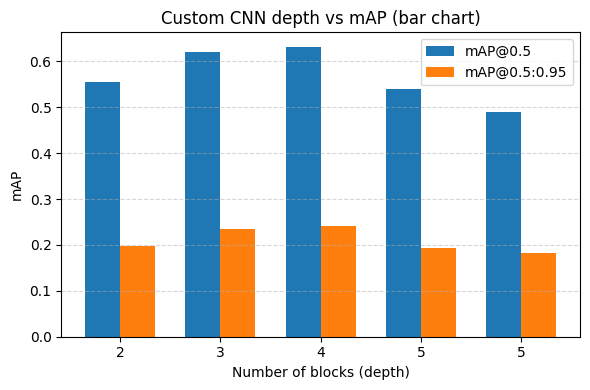

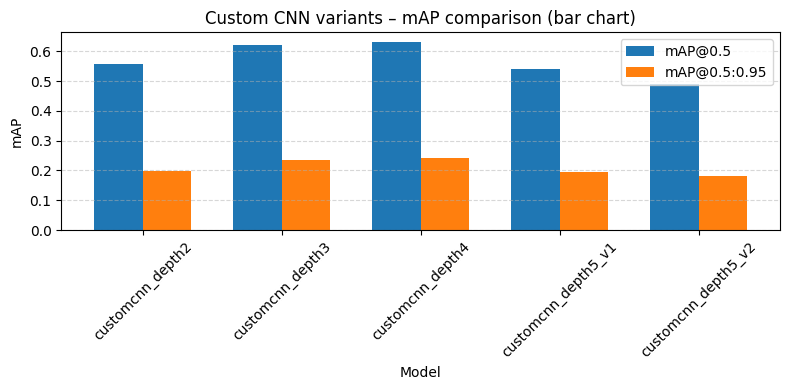

In [18]:


df_plot = df_depth_table.sort_values("num_blocks")

plt.figure(figsize=(6, 4))
x = np.arange(len(df_plot))
width = 0.35

plt.bar(x - width/2, df_plot["mAP_50"], width=width, label="mAP@0.5")
plt.bar(x + width/2, df_plot["mAP_50_95"], width=width, label="mAP@0.5:0.95")

plt.xticks(x, df_plot["num_blocks"])
plt.xlabel("Number of blocks (depth)")
plt.ylabel("mAP")
plt.title("Custom CNN depth vs mAP (bar chart)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
x = np.arange(len(df_plot))
width = 0.35

plt.bar(x - width/2, df_plot["mAP_50"], width=width, label="mAP@0.5")
plt.bar(x + width/2, df_plot["mAP_50_95"], width=width, label="mAP@0.5:0.95")

plt.xticks(x, df_plot["model_tag"], rotation=45)
plt.xlabel("Model")
plt.ylabel("mAP")
plt.title("Custom CNN variants – mAP comparison (bar chart)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
